## Abstract

This notebook attempts to predict the churning of bank clients after six (6) months based on the dataset (see [Bank Turnover Dataset](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)). The data is composed of 12 variables and 10,000 records.

Initially, a baseline was established using unscaled data to determine the best model which yieled the highest accuracy. At this stage, `XGB` topped all models
with an accuracy of 83.05%. 

Select variables (`CreditScore`, `Age`, `Tenure`, `Balance`, and `EstimatedSalary`) where then scaled and `SVC` achieved the highest accuracy rate
with 83.75% while `XGB` closely followed with 83.10%. 

Both `SVC` and `XGB` where then tuned based on a grid search. `SVC` used `C=0.1` and `kernel_values=linear` while `XGB` was tuned using`colsample_bytree=0.8`, `gamma=5`, `max_depth=4`, `min_child_weight=1`, and `subsample=1`, resulting to an accuracy score of 83.10% for `SVC` and a significant improvement for
`XGB` with 85.30%. 

Ensemble methods were used and it only yielded an accuracy score of 84.95% using `GradientBoosting`. 

Predicting the test dataset using the tuned `XGB` and `GradientBoosting` resulted to accuracy scores of 85.78% and 86.9%, respectively.

Interpreting the models, `NumOfProducts`, `Age`, and `Balance` are the top predictors for `XGB`. For `GradientBoosting`, `Age`, `NumOfProducts`, and `IsActiveMember` are the
top predictors of churn.

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from xgboost import plot_importance

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier


from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../input/bank-customer-churn-modeling/Churn_Modelling.csv')

## Remove RowNumber and Customer Id Columns

In [3]:
# Remove RowNumber and CustomerId
df = df.iloc[:,2:14]

# Add Surname2 col
foo = df['Surname'].value_counts()
foo = pd.DataFrame(foo)
foo['Name'] = foo.index
foo = foo[foo['Surname'] > 1]
foo = foo.Name.unique()
foo = list(foo)
foo.sort()
len(foo)
len(df.Surname.unique())
df['Surname2'] = 0
df.loc[df['Surname'].isin(foo), ['Surname2']] = 1

# # Remove Surname col
# df = df.iloc[:,1:14]

# Rearrange cols
cols = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Surname2', 'Exited']

df = df[cols]
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Surname2,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,0,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,1,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,1,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,1,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,1,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1


## Plot of Variables

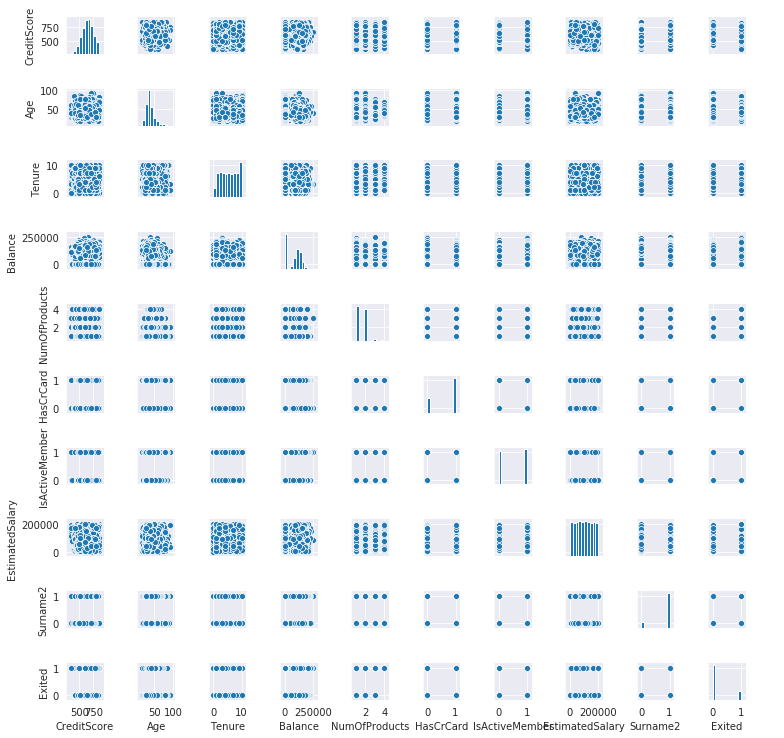

In [4]:
# Analyze numeric cols
num_cols = ['CreditScore', 'Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary', 'Surname2', 'Exited']
df_num = df[num_cols]

sns.set_style('darkgrid')
sns.pairplot(df_num, height=1)

#...scale CreditScore, Age, Tenure, Balance, EstimatedSalary
# NumOfProducts is already categorized
#...retain binomial: HasCrCard, IsActiveMember, Surname2

## Re-encode Label Columns

In [5]:
lab_enc = LabelEncoder()
cols = ['Geography','Gender']

for _ in cols:
    df[_] = lab_enc.fit_transform(df[_])
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Surname2,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,0,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,1,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,1,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,39,5,0.00,2,1,0,96270.64,1,0
9996,516,0,1,35,10,57369.61,1,1,1,101699.77,1,0
9997,709,0,0,36,7,0.00,1,0,1,42085.58,1,1
9998,772,1,1,42,3,75075.31,2,1,0,92888.52,1,1


## Create Train and Test Data

In [6]:
x = df.iloc[:,0:11]
y = df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.2, random_state=7)

## Compare Algorithms on Unscaled Data

In [7]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('XGB', XGBClassifier()))
models

[('LR',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=1000,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False)),
 ('CART',
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=None, splitter='best')),
 ('LDA',
  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                             solver='svd', store_covariance=False, tol=0.0001)),
 ('KNN',
  KNeighborsClassifier(alg

In [8]:
my_cv = []
my_names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    my_names.append(name)
    my_cv.append(cv)
    msg = ('%s %f (%f)' % (name, cv.mean(), cv.std()))
    print(msg)

LR 0.788500 (0.026557)
CART 0.763500 (0.032791)
LDA 0.795500 (0.031341)
KNN 0.753500 (0.028814)
SVC 0.790500 (0.024945)
XGB 0.830500 (0.018500)


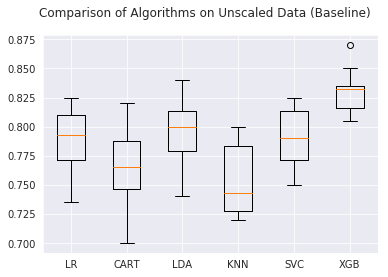

In [9]:
fig = plt.figure()
fig.suptitle('Comparison of Algorithms on Unscaled Data (Baseline)')
ax = fig.add_subplot(111)
plt.boxplot(my_cv)
ax.set_xticklabels(my_names)
plt.show()
#...XGB has the highest accuracy at 83.05% with a std of 0.01850

## Comparison of Algorithms on Scaled Data

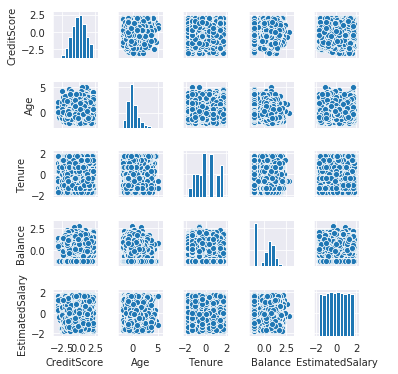

In [10]:
df_all_cols = df.columns
cols = ['CreditScore','Age','Tenure','Balance','EstimatedSalary']
cols2 = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Surname2', 'Exited']

df_cats = df[cols]
scaler = StandardScaler().fit(df_cats)
foo = pd.DataFrame(scaler.transform(df_cats))
foo.columns = ['CreditScore','Age','Tenure','Balance','EstimatedSalary']

df_scaled = pd.concat([foo, df[cols2]], axis=1)

sns.set_style('darkgrid')
sns.pairplot(df_scaled[cols], height=1)

## Create Train and Test Split from Scaled Data

In [11]:
x = df_scaled.iloc[:,0:11]
y = df_scaled.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.2, random_state=7)

In [12]:
my_cv = []
my_names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    my_names.append(name)
    my_cv.append(cv)
    msg = ('%s %f (%f)' % (name, cv.mean(), cv.std()))
    print(msg)

LR 0.801500 (0.031309)
CART 0.763000 (0.034728)
LDA 0.795500 (0.031341)
KNN 0.802500 (0.031879)
SVC 0.837500 (0.026481)
XGB 0.831000 (0.018276)


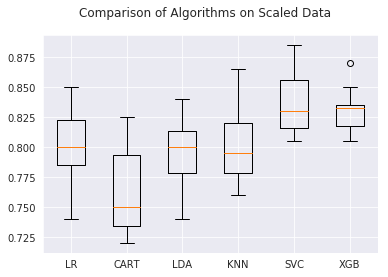

In [13]:
fig = plt.figure()
fig.suptitle('Comparison of Algorithms on Scaled Data')
ax = fig.add_subplot(111)
plt.boxplot(my_cv)
ax.set_xticklabels(my_names)
plt.show()\
#...SVC's accuracy significantly jumped to 83.75% with an std of 0.026481

## Tune SVC and Use on Scaled Data

In [14]:
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)

#Note: x_train data that was used is scaled
model = XGBClassifier()
kfold = KFold(n_splits = 10, random_state=7)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with %r' % (mean, stdev, param))
#...accuracy for tuned SVC on scaled data slightly worsened to 83.10%

Best: 0.831000 using {'C': 0.1, 'kernel': 'linear'}
0.831000 (0.018276) with {'C': 0.1, 'kernel': 'linear'}
0.831000 (0.018276) with {'C': 0.1, 'kernel': 'poly'}
0.831000 (0.018276) with {'C': 0.1, 'kernel': 'rbf'}
0.831000 (0.018276) with {'C': 0.1, 'kernel': 'sigmoid'}
0.831000 (0.018276) with {'C': 0.3, 'kernel': 'linear'}
0.831000 (0.018276) with {'C': 0.3, 'kernel': 'poly'}
0.831000 (0.018276) with {'C': 0.3, 'kernel': 'rbf'}
0.831000 (0.018276) with {'C': 0.3, 'kernel': 'sigmoid'}
0.831000 (0.018276) with {'C': 0.5, 'kernel': 'linear'}
0.831000 (0.018276) with {'C': 0.5, 'kernel': 'poly'}
0.831000 (0.018276) with {'C': 0.5, 'kernel': 'rbf'}
0.831000 (0.018276) with {'C': 0.5, 'kernel': 'sigmoid'}
0.831000 (0.018276) with {'C': 0.7, 'kernel': 'linear'}
0.831000 (0.018276) with {'C': 0.7, 'kernel': 'poly'}
0.831000 (0.018276) with {'C': 0.7, 'kernel': 'rbf'}
0.831000 (0.018276) with {'C': 0.7, 'kernel': 'sigmoid'}
0.831000 (0.018276) with {'C': 0.9, 'kernel': 'linear'}
0.831000 (0.

## Tune XGB and Use on Scaled Data**

In [15]:
min_child_weight = [1, 5, 10]
gamma = [0.5, 1, 1.5, 2, 5]
subsample = [0.6, 0.8, 1.0]
colsample_bytree =  [0.6, 0.8, 1.0]
max_depth = [3, 4, 5]
        
param_grid = dict(min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree, max_depth = max_depth)
model = XGBClassifier()
kfold = KFold(n_splits = 10, random_state=7)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with %r' % (mean, stdev, param))
#...the accuracy of the tuned xgb on scaled data significantly jumped to 85.3% using colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=1, and subsample=1

Best: 0.853000 using {'colsample_bytree': 0.8, 'gamma': 5, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1.0}
0.824500 (0.017812) with {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
0.835500 (0.015564) with {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
0.843000 (0.018868) with {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
0.831000 (0.019975) with {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6}
0.837000 (0.021237) with {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8}
0.841000 (0.016703) with {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}
0.824000 (0.020833) with {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6}
0.830500 (0.024439) with {'co

## Ensemble Methods

In [16]:
ensembles = []
ensembles.append(('ADA', AdaBoostClassifier()))
ensembles.append(('GB', GradientBoostingClassifier()))
ensembles.append(('BC', BaggingClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))

In [17]:
my_cv = []
my_names = []

#
for name, model in ensembles:
    kfold = KFold(n_splits=10, random_state=7)
    cv = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    my_names.append(name)
    my_cv.append(cv)
    msg = ('%s %f (%f)' % (name, cv.mean(), cv.std()))
    print(msg)

ADA 0.837000 (0.025020)
GB 0.850000 (0.022136)
BC 0.835000 (0.022472)
ET 0.841500 (0.022366)


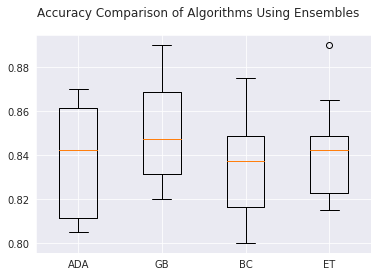

In [18]:
fig = plt.figure()
fig.suptitle('Accuracy Comparison of Algorithms Using Ensembles')
ax = fig.add_subplot(111)
plt.boxplot(my_cv)
ax.set_xticklabels(my_names)
plt.show()
#...GB resulted to 84.95 using scaled data

## Predict Using Tuned XGB on Scaled Data

0.857875
[[6190  192]
 [ 945  673]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6382
           1       0.78      0.42      0.54      1618

    accuracy                           0.86      8000
   macro avg       0.82      0.69      0.73      8000
weighted avg       0.85      0.86      0.84      8000



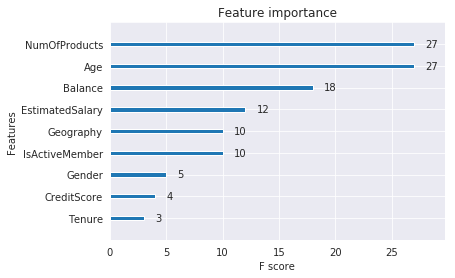

In [19]:
model = XGBClassifier(colsample_bytree=0.8, gamma=5, max_depth=4, min_child_weight=1, subsample=1)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
plot_importance(model)
#...accuracy is at 85.78%, important vars are NumOfProducts, Age, and Balance

## Predict Using Gradient Boosting on Scaled Data

In [20]:
model = GradientBoostingClassifier()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(model.feature_importances_)
print(x_test.columns)
#...acccuracy is highest at 85.9%

0.859125
[[6177  205]
 [ 922  696]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6382
           1       0.77      0.43      0.55      1618

    accuracy                           0.86      8000
   macro avg       0.82      0.70      0.73      8000
weighted avg       0.85      0.86      0.84      8000

[0.0516444  0.34016882 0.01946186 0.10072738 0.05011393 0.01594623
 0.01394699 0.28339971 0.00163974 0.11666444 0.0062865 ]
Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary',
       'Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'Surname2'],
      dtype='object')
